# Implementation of a Variational Recurrent Neural Network

Dynamical VAEs survey paper : https://arxiv.org/abs/2008.12595

Import generic libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns

Import VRNN library

In [2]:
from libs.vrnn_lib_astra import seed_everything, VRNN
# from libs.vrnn_lib_astra import loss_function, train
# from libs.vrnn_lib_astra import BetaLinearScheduler, BetaThresholdScheduler
# from libs.vrnn_lib_astra import plot_losses #, sample_predictions

In [3]:
# Set seed for reproducibility
seed_everything(42)

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(f"Using {device}")

torch.set_default_dtype(torch.float64)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda
GPU Name: NVIDIA GeForce RTX 3090
Total GPU Memory: 23.7 GB


# Model

### Variational RNN :

The full factorization of $p(z_{1:T}, x_{1:T})$ is used:

\begin{align}
p(z_{1:T}, x_{1:T}) &= \prod_{t=1}^T p(z_t, x_t \vert z_{1:t-1}, x_{1:t-1}) \\
&= \prod_{t=1}^T p_{\theta_x}(x_t \vert x_{1:t-1}, z_{1:t}) p_{\theta_z}(z_t \vert z_{1:t-1}, x_{1:t-1}) \\
\end{align}

Where the two distributions $p_{\theta_z}$ and $p_{\theta_x}$ are Gaussians :

\begin{align}

p_{\theta_x}(x_t \vert x_{1:t-1}, z_{1:t}) &= \mathcal{N}(x_t \vert \mu_{\theta_x}(\overrightarrow{g}_{t-1}, h_{t}), \text{diag}(\sigma_{\theta_x}^{2}(\overrightarrow{g}_{t-1}, h_{t}))) \\
d_x(\overrightarrow{g}_{t-1}, h_{t}) &= [ \mu_{\theta_x}(\overrightarrow{g}_{t-1}, h_{t}), \sigma_{\theta_x}(\overrightarrow{g}_{t-1}, h_{t}) ] \\

p_{\theta_z}(z_t \vert z_{1:t-1}, x_{1:t-1}) &= \mathcal{N}(z_t \vert \mu_{\theta_z}(\overrightarrow{g}_{t-1}, h_{t-1}), \text{diag}(\sigma_{\theta_z}^{2}(\overrightarrow{g}_{t-1}, h_{t-1}))) \\
d_z(\overrightarrow{g}_{t-1}, h_{t-1}) &= [ \mu_{\theta_z}(\overrightarrow{g}_{t-1}, h_{t-1}), \sigma_{\theta_z}(\overrightarrow{g}_{t-1}, h_{t-1}) ] \\

\end{align}

where $d_x, d_z$ are MLP (multi-layer perceptron) networks,

and where $h_t = \text{LSTM}(z_t, h_{t-1})$ is a forward LSTM that encodes $z_{1:t}$

and $\overrightarrow{g}_t = \text{LSTM}(x_t, \overrightarrow{g}_{t-1})$ is a forward LSTM that encodes $x_{1:t}$

### Model inference

The true posterior writes :
\begin{align}
p_{\theta}(z_{1:T} \vert x_{1:T}) &= \prod_{t=1}^T p_{\theta} (z_t \vert z_{1:t-1}, x_{1:T} ) \\
\end{align}

which is the strict application of the chain rule.

The approximate posterior (ie encoder) is formed with the same expression as the true posterior :

\begin{align}
q_{\phi}(z_{1:T} \vert x_{1:T}) &= \prod_{t=1}^T q_{\phi} (z_{t} \vert z_{1:t-1}, x_{1:T}) \\
\end{align}

And:
\begin{align}
q_{\phi} (z_{t} \vert z_{1:t-1}, x_{1:T}) &= \mathcal{N}(z_t \vert \mu_{\phi}(h_{t-1}, \overrightarrow{g}_{t-1}, \overleftarrow{g}_{t}), \text{diag} (\sigma_{\phi}^2(h_{t-1}, \overrightarrow{g}_{t-1}, \overleftarrow{g}_{t}))) \\
d_{\phi}(h_{t-1}, \overrightarrow{g}_{t-1}, \overleftarrow{g}_{t}) &= [ \mu_{\phi}(h_{t-1}, \overrightarrow{g}_{t-1}, \overleftarrow{g}_{t}), \sigma_{\phi}(h_{t-1}, \overrightarrow{g}_{t-1}, \overleftarrow{g}_{t}) ]
\end{align}

where $d_{\phi}$ is a MLP, and

$\overleftarrow{g}_t = \text{LSTM}(x_t, \overleftarrow{g}_{t-1})$ is a backward LSTM that encodes $x_{t:T}$

# Inference implementation

Some implementation details are different from the ones in the original paper:

- **three** distinct LSTMs encode $z_{1:t}$, $x_{1:t}$ et $x_{t:T}$, whereas a single one is used in the paper.

- there is no feature extractor for $x$ and $z$, as we intend to work primarily with time series.

# Training

The model trains by maximizing an Evidence Lower Bound (ELBO), which writes for VRNN:

\begin{align}
    \begin{split}
    \mathcal{L}(\theta, \phi; X) &= \sum_{t=1}^T  \mathbb{E}{q_{\phi}(z_{1:t} \vert x_{1:T})} \log{p_{\theta_x}(x_t \vert x_{1:t-1}, z_{1:t})} \\ &- \sum_{t=1}^T \mathbb{E}{q_{\phi}(z_{1:t-1} \vert x_{1:T})} \mathbb{KL}{q_{\phi}(z_t \vert z_{1:t-1}, x_{1:T})}{p_{\theta_z}(z_t \vert z_{1:t-1}, x_{1:t-1})} 
    \end{split}    
\end{align}

The two terms are: (with $D$ dimension of the observation space) :

\begin{align}
p_{\theta_x}(x_t \vert z_t) &= \mathcal{N}(x_t \vert \mu_{\theta_x}(z_t), \text{diag}(\sigma_{\theta_x}^2(z_t))) \\
\log{p_{\theta_x}(x_t \vert z_t)} &= -\frac{D}{2} \log{2\pi} - \frac{1}{2}\log{\vert \text{diag}(\sigma_{\theta_x}^2(z_t)) \vert} - 
\frac{1}{2} \left[ (x_t - \mu_{\theta_x}(z_t))^T (\text{diag}(\sigma_{\theta_x}^2(z_t)))^{-1} (x_t - \mu_{\theta_x}(z_t)) \right] \\
&= - \frac{1}{2} \left( \sum_{i=1}^D \log{\sigma_{\theta_x}^2(z_t)}\vert_{i} + (x_t - \mu_{\theta_x}(z_t))^T \text{diag} \frac{1}{\sigma_{\theta_x}^2(z_t)} (x_t - \mu_{\theta_x}(z_t)) + D \log{2\pi} \right)
\end{align}

The Kullback Liebler divergence writes between the two gaussians:

\begin{align}
q_\phi(z_t \vert z_{t-1}, x_{t:T}) &= \mathcal{N}(z_t \vert \mu_{\phi}(g_t), \text{diag}(\sigma_\phi^2(g_t))) \\
p_{\theta_z}(z_t \vert z_{t-1}) &= \mathcal{N}(z_t \vert \mu_{\theta_z}(z_{t-1}), \text{diag}(\sigma_{\theta_z}^{2}(z_{t-1}))) \\
\end{align}

with a close form solution ($Z$ dimension of the latent space):

\begin{align}
\text{D}_{\text{KL}}(q_\phi \vert\vert p_{\theta_z}) &= \frac{1}{2} \left[ \text{Tr}(\text{diag}(\sigma_{\theta_z}^{2})^{-1} \text{diag}(\sigma_\phi^2) ) + (\mu_{\theta_z} - \mu_\phi)^T (\text{diag}(\sigma_{\theta_z}^{2})^{-1}) (\mu_{\theta_z} - \mu_\phi) +
\log{\frac{\vert \text{diag}(\sigma_{\theta_z}^{2})\vert}{\vert \text{diag}(\sigma_\phi^2) \vert} } \right] \\
&= \frac{1}{2}\left[ \sum_{i=1}^Z \log{\sigma_{\theta_z}^{2}}\vert_i - \sum_{i=1}^Z \log{\sigma_{\phi}^{2}}\vert_i +
 (\mu_{\theta_z} - \mu_\phi)^T \text{diag}(\frac{1}{\sigma_{\theta_z}^{2}}) (\mu_{\theta_z} - \mu_\phi) + \sum_{i=1}^Z \frac{\sigma_{\phi}^{2}\vert_i} {\sigma_{\theta_z}^{2}\vert_i} - Z 
\right]
\end{align}

# Parameters

In [5]:
X_DIM = 1 # Dimension of the observation space
Z_DIM = 32 # Dimension of the latent space
RNN_X_H_DIM = 128 # Dimension of the hidden state of the bidirectional LSTM network for observations
RNN_Z_H_DIM = 128 # Dimension of the hidden state of the bidirectional LSTM network for latent variables

# Toy Case : Data Generation for Time Series Forecasting

In [6]:
n_steps = 50
n_ahead = 20
n_series = 100
noise = 0.05

def generate_time_series(batch_size, n_steps, noise=noise):
    """Utility function to generate time series data.

    Args:
        batch_size (int): number of time series to generate (btach size)
        n_steps (_type_): length of each time series
    """
    
    f1,f2,o1,o2 = np.random.rand(4, batch_size, 1)  # return 4 values for each time series
    time = np.linspace(0, 1, n_steps)  # time vector
    
    series = 0.4 * np.sin((time - o1) * (f1 * 5 + 10)) # first sine wave
    series += 0.2 * np.sin((time - o2) * (f2 * 20 + 20)) # second sine wave
    series += noise * (np.random.randn(batch_size, n_steps) - 0.5)  # add noise
    
    return series

Draw some samples of the synthetic data

In [7]:
s = generate_time_series(n_series, n_steps+n_ahead)

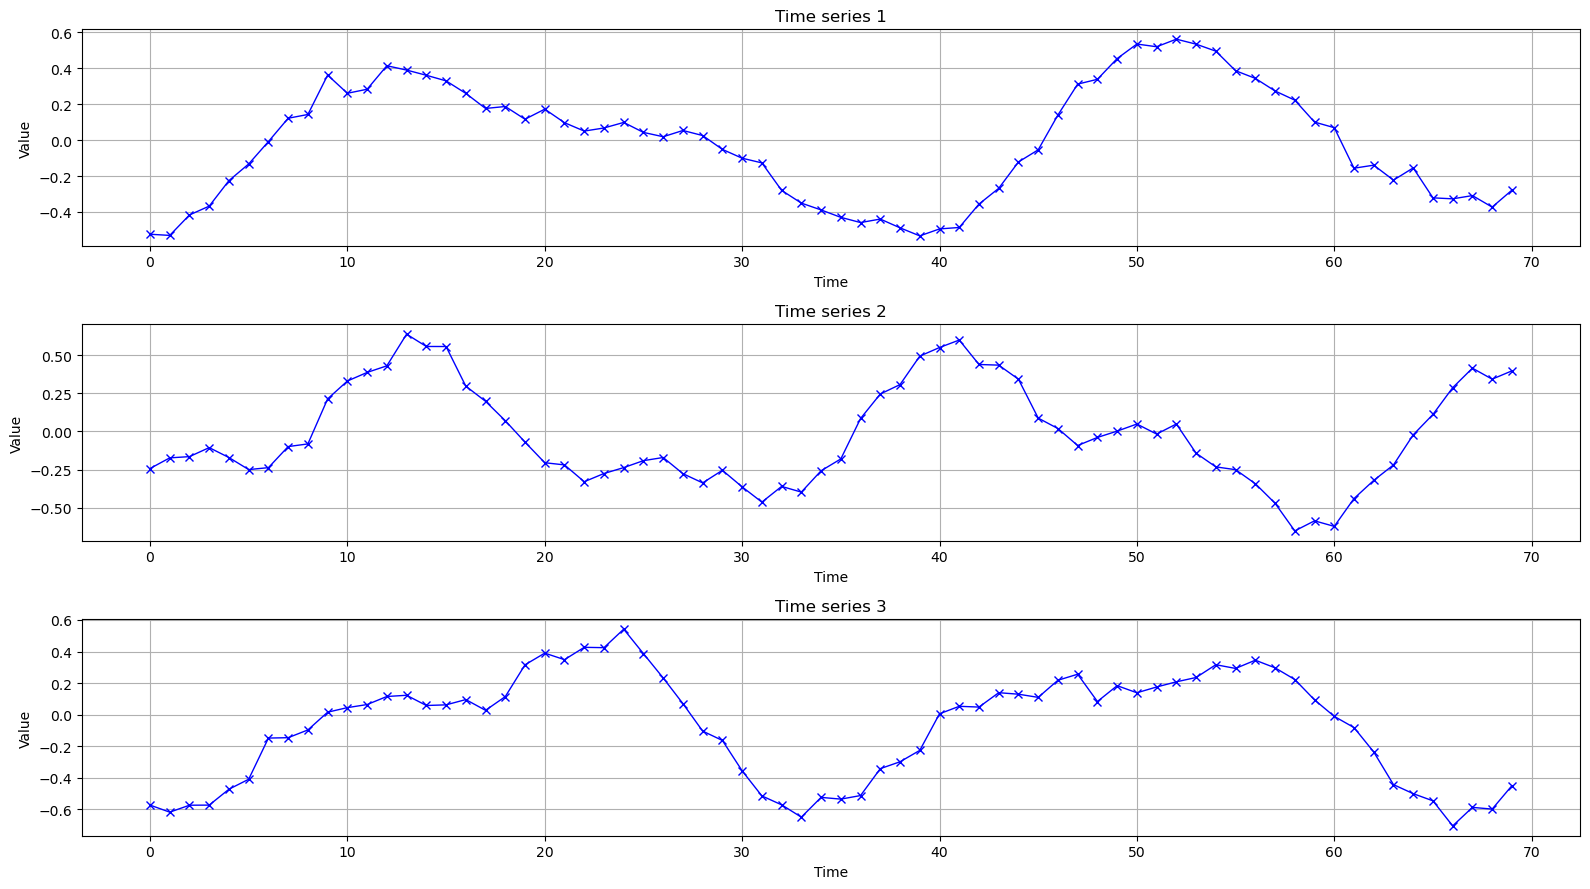

In [8]:
N = 3
fig, axs = plt.subplots(N, 1, figsize=(16, 3 * N))
for i in range(N):
    axs[i].plot(s[i], color='blue', marker="x", linewidth=1)
    axs[i].set_title(f"Time series {i+1}")
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Value")
    axs[i].grid(True)
plt.tight_layout()
plt.show()

Form train test split

In [9]:
cutoff = int(0.8 * n_series)

X_train, y_train = s[:cutoff,:n_steps], s[:cutoff,n_steps:]
X_valid, y_valid = s[cutoff:,:n_steps], s[cutoff:,n_steps:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")

X_train shape: (80, 50)
y_train shape: (80, 20)
X_valid shape: (20, 50)
y_valid shape: (20, 20)


Form datasets and dataloaders for the PyTorch training

In [10]:
BATCH_SIZE = 64  # up to 8192 ok with a RTX3080 and 150 time steps

from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).to(device)
        self.y = torch.tensor(y).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_valid, y_valid)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Training a VRNN

Resource video:

https://www.youtube.com/watch?v=rz76gYgxySo&list=WL&index=1&t=1618s&ab_channel=SimonLeglaive

<div>
<img src="/home/benjamin.deporte/MVA/MVA_Stage/vrnn3.jpg" width="1000"/>
</div>

In [11]:
X_DIM = 1 # Dimension of the observation space
Z_DIM = 32 # Dimension of the latent space
RNN_X_H_DIM = 128 # Dimension of the hidden state of the bidirectional LSTM network for observations
RNN_Z_H_DIM = 128 # Dimension of the hidden state of the bidirectional LSTM network for latent variables

In [12]:
vrnn = VRNN(
    input_dim = X_DIM,
    latent_dim = Z_DIM,
    rnn_x_hidden_dim = RNN_X_H_DIM,
    rnn_z_hidden_dim = RNN_Z_H_DIM,
    device=device
).to(device)

print(vrnn)

VRNN(observation_dim=1, latent_dim=32)
Bidirectional LSTM (input_size=1, rnn_x_hidden_size=128, num_layers=1)
Forward LSTM (input_size=32, rnn_z_hidden_size=128, num_layers=1)
Encoder MLP (z_dim=32, rnn_z_hidden_dim=128, rnn_x_hidden_dim=128)
Sequential(
  (0): Linear(in_features=384, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=64, bias=True)
)
Latent State Transition MLP (z_dim=32, rnn_z_hidden_dim=128, rnn_x_hidden_dim=128)
Sequential(
  (0): Linear(in_features=256, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=64, bias=True)
)
Decoder MLP (x_dim=1, rnn_z_hidden_dim=128, rnn_x_hidden_dim=128)
Sequential(
  (0): Linear(in_features=256, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_

Training functions

In [13]:
#----------------------------------------------------------------------
#
# Loss Function
#
#----------------------------------------------------------------------

def loss_function(x_t, mu_x_t, logvar_x_t, mu_phi_z_t, logvar_phi_z_t, mu_theta_z_t, logvar_theta_z_t, beta=None):
    # """
    # Version 2.0 of the loss function for the VRNN.
    # All distributions parameters are assumed to have been computed from K samples of each z_t.
    # The K samples are used to compute the expectations within the loss function.

    # Args:
    #     x_t (tensor): the original input sequence - shape (seq_len, batch_size, x_dim)

    #     mu_x_t (tensor): the mean of the distribution of the observed variable - shape (seq_len, batch_size, x_dim, K)
    #     logvar_x_t (tensor): the log of the variance of the distribution of the observed variable - shape (seq_len, batch_size, x_dim, K)
    #     mu_phi_z_t (tensor): the mean of the approximate posterior distribution (q_\phi) of the latent variable - shape (seq_len, batch_size, z_dim, K)
    #     logvar_phi_z_t (tensor): the log of the variance of the approximate posterior distribution (q_\phi) of the latent variable - shape (seq_len, batch_size, z_dim, K)
    #     mu_theta_z_t (tensor): the mean of the transition distribution (p_\theta_z) of the latent variable - shape (seq_len, batch_size, z_dim, K)
    #     logvar_theta_z_t (tensor): the log of the variance of the transition distribution (p_\theta_z) of the latent variable - shape (seq_len, batch_size, z_dim, K)

    #     beta (float, optional): the weight of the KL divergence term in the loss function. Defaults to None.
        
    # Returns:
    #     rec_loss (tensor): the reconstruction loss - shape (1,)
    #     kl_loss (tensor): the KL divergence loss - shape (1,)
    #     total_loss (tensor): the total loss - shape (1,)
    # """
    
    seq_len, batch_size, x_dim = x_t.shape
    
    # choose beta
    if beta is None:
        beta = 1.0
        
    # check whether there is a K dimension or not, add K=1 if none given
    if mu_x_t.dim() == 3:
        K = 1
        mu_x_t = mu_x_t.unsqueeze(-1)
        logvar_x_t = logvar_x_t.unsqueeze(-1)
        mu_phi_z_t = mu_phi_z_t.unsqueeze(-1)
        logvar_phi_z_t = logvar_phi_z_t.unsqueeze(-1)
        mu_theta_z_t = mu_theta_z_t.unsqueeze(-1)
        logvar_theta_z_t = logvar_theta_z_t.unsqueeze(-1)
    else:
        K = mu_x_t.shape[-1]
        
    z_dim = mu_phi_z_t.shape[-2]
        
    # compute the expectation of the reconstruction loss with K samples
    
    x_t_extended = x_t.unsqueeze(-1)  # (seq_len, batch_size, x_dim, K)
    var_x = logvar_x_t.exp() # (seq_len, batch_size, x_dim, K)
    
    rec_loss = torch.div((x_t_extended - mu_x_t)**2, var_x)  # (seq_len, batch_size, x_dim, K) - x_t_extended is broadcasted along last axis
    rec_loss += logvar_x_t # (seq_len, batch_size, x_dim, K)
    
    rec_loss = torch.mean(rec_loss, dim=3)  # Mean over the K samples - (seq_len, batch_size, x_dim)
    rec_loss = torch.sum(rec_loss, dim=2)  # Sum over the x_dim - (seq_len, batch_size)
    rec_loss += x_dim * torch.log(2 * torch.tensor(torch.pi))  # (seq_len, batch_size) - pour normaliser
    rec_loss = torch.sum(rec_loss, dim=0)  # Sum over the sequence length - (batch_size)
    rec_loss = torch.mean(rec_loss)  # Mean over the batch - ()
    
    rec_loss = 1/2 * (rec_loss / seq_len)
    
    # compute the expectation of the KL divergence loss with K samples
    
    kl_loss = logvar_theta_z_t - logvar_phi_z_t  # (seq_len, batch_size, z_dim, K)
    kl_loss += torch.div(logvar_phi_z_t.exp(), logvar_theta_z_t.exp()) # (seq_len, batch_size, z_dim, K)
    kl_loss += torch.div((mu_theta_z_t - mu_phi_z_t).pow(2), logvar_theta_z_t.exp())
       
    kl_loss = torch.mean(kl_loss, dim=3)  # Mean over the K samples - (seq_len, batch_size, z_dim)
    kl_loss = torch.sum(kl_loss, dim=2)  # Sum over the z_dim - (seq_len, batch_size)
    kl_loss -= z_dim # shape (seq_len, batch_size), normalisation
    kl_loss = torch.sum(kl_loss, dim=0)  # Sum over the sequence length - (batch_size)
    kl_loss = torch.mean(kl_loss)  # Mean over the batch
    
    kl_loss = 1/2 * kl_loss / seq_len
    
    return rec_loss, kl_loss, rec_loss + beta * kl_loss

In [14]:
def train_step(model, optimizer, loss_fn, train_loader=None, device=None, beta=None, K=None):
    ### training step
    model.train()
    optimizer.zero_grad()
    ### loop on training data
    rec_loss = 0
    kl_loss = 0
    epoch_loss = 0
    ### check on K
    if K is None:
        K=1
        
    x_dim = model.input_dim
    latent_dim = model.latent_dim
    
    for input, _ in train_loader:
        input = input.to(device).unsqueeze(-1)  # add a feature dimension
        input = input.permute(1, 0, 2)  # permute to (seq_len, batch_size, input_dim)

        mu_x_t = torch.zeros(input.shape[0], input.shape[1], x_dim, K).to(device)
        logvar_x_t = torch.zeros(input.shape[0], input.shape[1], x_dim, K).to(device)
        mu_phi_z_t = torch.zeros(input.shape[0], input.shape[1], latent_dim, K).to(device)
        logvar_phi_z_t = torch.zeros(input.shape[0], input.shape[1], latent_dim, K).to(device)
        mu_theta_z_t = torch.zeros(input.shape[0], input.shape[1], latent_dim, K).to(device)
        logvar_theta_z_t = torch.zeros(input.shape[0], input.shape[1], latent_dim, K).to(device)

        # get K samples of the parameters of each distribution
        for k in range(K):
            # get the parameters of the distributions
            _, mu_x_t[:, :, :, k], logvar_x_t[:, :, :, k], mu_phi_z_t[:, :, :, k], logvar_phi_z_t[:, :, :, k], mu_theta_z_t[:, :, :, k], logvar_theta_z_t[:, :, :, k] = model(input)
        
        rec_loss, kl_loss, total_loss = loss_fn(input, mu_x_t, logvar_x_t, mu_phi_z_t, logvar_phi_z_t, mu_theta_z_t, logvar_theta_z_t, beta=beta)
        
        total_loss.backward()
        optimizer.step()
              
        rec_loss += rec_loss.item()
        kl_loss += kl_loss.item()
        epoch_loss += total_loss.item()
        
    epoch_loss /= len(train_loader)
    rec_loss /= len(train_loader)
    kl_loss /= len(train_loader)
    
    return rec_loss, kl_loss, epoch_loss

In [15]:
# Test step : perform validation test for one epoch

def test_step(model, loss_fn, test_loader=None, device=None, beta=None):
    ### test step
    model.eval()
    
    with torch.no_grad():
        ### loop on test data
        rec_loss = 0
        kl_loss = 0
        epoch_loss = 0
        
        for input, _ in test_loader:
            input = input.to(device).unsqueeze(-1)  # add a feature dimension
            input = input.permute(1, 0, 2)  # permute to (seq_len, batch_size, input_dim)

            _, mu_x_s, logvar_x_s, mu_z_s, logvar_z_s, mu_z_transition_s, logvar_z_transition_s = model(input)
            
            rec_loss, kl_loss, total_loss = loss_fn(input, mu_x_s, logvar_x_s, mu_z_s, logvar_z_s, mu_z_transition_s, logvar_z_transition_s, beta=beta)
                
            rec_loss += rec_loss.item()
            kl_loss += kl_loss.item()
            epoch_loss += total_loss.item()
            
        epoch_loss /= len(test_loader)
        rec_loss /= len(test_loader)
        kl_loss /= len(test_loader)
    
    return rec_loss, kl_loss, epoch_loss

In [16]:
# Train function

def train(model, optimizer, loss_fn, num_epochs=100, train_loader=None, test_loader=None, batch_size=None, device=None, beta=None, display_frequency=10, K=None):
    
    rec_losses = []
    kl_losses = []
    epoch_losses = []

    val_rec_losses = []
    val_kl_losses = []
    val_epoch_losses = []
    
    betas = []
    rec_loss = 1.0
    
    if K is None:
        K = 1
    else:
        K = int(K)
        
    print(f"Starting training...")
    if device.type == 'cuda':
        print('GPU Name:', torch.cuda.get_device_name(0))
        print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')
    print(f"Number of epochs: {num_epochs}")
    print(f"Learning rate: {optimizer.param_groups[0]['lr']:.3e}")
    print(f"Batch size: {batch_size}")
    # if beta_scheduler is not None:
    #     print(f"Beta scheduler: {beta_scheduler}")
    # else:
    #     print(f"Beta scheduler: None, beta = {beta:.3e}")
    print(f"K = {K}")
    print(f"Training set size: {len(train_loader.dataset)}")
    print(f"Validation set size: {len(test_loader.dataset)}")
    print(f"Device: {device}")
    print(f"\n")

    for i in range(num_epochs):
        
        # use the beta scheduler if provided
        # if beta_scheduler is not None:
        #     beta = beta_scheduler(i, rec_loss)
        betas.append(beta)
        
        # run the training step
        rec_loss, kl_loss, epoch_loss = train_step(model, optimizer, loss_fn, train_loader=train_loader, device=device, beta=beta, K=K)

        # log results
        rec_losses.append(rec_loss)
        kl_losses.append(kl_loss)
        epoch_losses.append(epoch_loss)
        
        # run test step
        val_rec_loss, val_kl_loss, val_epoch_loss = test_step(model, loss_fn, test_loader=test_loader, device=device, beta=beta)
            
        # log results
        val_rec_losses.append(val_rec_loss)
        val_kl_losses.append(val_kl_loss)
        val_epoch_losses.append(val_epoch_loss)
        
        # Print the losses for this epoch
        if (i+1) % display_frequency == 0:
            print(f"Epoch {i+1:>5}/{num_epochs} with beta = {beta:.2e} - TRAINING : Rec Loss: {rec_loss:.4e}, KL Loss: {kl_loss:.4e}, Total Loss: {epoch_loss:.4e} - TEST : Rec Loss: {val_rec_loss:.4e}, KL Loss: {val_kl_loss:.4e}, Total Loss: {val_epoch_loss:.4e}")
            
    return rec_losses, kl_losses, epoch_losses, val_rec_losses, val_kl_losses, val_epoch_losses, betas        

In [17]:
optimizer = torch.optim.Adam(vrnn.parameters(), lr=1e-3)
loss_fn = loss_function

# K is the number of samples to use for estimating the expectation over the posterior distribution
K = 5

In [18]:
num_epochs = 3
n_displays = 250
display_frequency = max(int(num_epochs / n_displays),1)

In [19]:
rec_losses, kl_losses, epoch_losses, val_rec_losses, val_kl_losses, val_epoch_losses, betas = train(
    vrnn, 
    optimizer, 
    loss_fn, 
    num_epochs=num_epochs, 
    train_loader=train_loader, 
    test_loader=test_loader, 
    batch_size=BATCH_SIZE, 
    device=device, 
    beta=1.0,
    display_frequency=display_frequency, 
    K=K
)

Starting training...
GPU Name: NVIDIA GeForce RTX 3090
Total GPU Memory: 23.7 GB
Number of epochs: 3
Learning rate: 1.000e-03
Batch size: 64
K = 5
Training set size: 80
Validation set size: 20
Device: cuda


Epoch     1/3 with beta = 1.00e+00 - TRAINING : Rec Loss: 9.8049e-01, KL Loss: 1.1906e+00, Total Loss: 2.2339e+00 - TEST : Rec Loss: 1.9401e+00, KL Loss: 2.1907e+00, Total Loss: 2.0654e+00
Epoch     2/3 with beta = 1.00e+00 - TRAINING : Rec Loss: 9.5944e-01, KL Loss: 1.0124e+00, Total Loss: 2.0197e+00 - TEST : Rec Loss: 1.8979e+00, KL Loss: 1.8755e+00, Total Loss: 1.8867e+00
Epoch     3/3 with beta = 1.00e+00 - TRAINING : Rec Loss: 9.3985e-01, KL Loss: 8.7182e-01, Total Loss: 1.8498e+00 - TEST : Rec Loss: 1.8502e+00, KL Loss: 1.6237e+00, Total Loss: 1.7369e+00


Report on the training

In [20]:
#----------------------------------------------------------------------
#
# Plotting functions
#
#----------------------------------------------------------------------

def plot_losses(rec_losses, kl_losses, epoch_losses, val_rec_losses, val_kl_losses, val_epoch_losses, betas):
    
    # Plot the losses

    fig, axs = plt.subplots(1, 4, figsize=(20, 3))

    axs[0].plot(torch.tensor(rec_losses).cpu().detach(), label='Training', color='blue')
    axs[0].plot(torch.tensor(val_rec_losses).cpu().detach(), label='Test', color='green')
    axs[0].set_title('Reconstruction Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid()

    axs[1].plot(torch.tensor(kl_losses).cpu().detach(), label='Training', color='blue')
    axs[1].plot(torch.tensor(val_kl_losses).cpu().detach(), label='Test', color='green')
    axs[1].set_title('KL Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    axs[1].grid()

    axs[2].plot(torch.tensor(epoch_losses).cpu().detach(), label='Training', color='blue')
    axs[2].plot(torch.tensor(val_epoch_losses).cpu().detach(), label='Test', color='green')
    axs[2].set_title('Total Loss')
    axs[2].set_xlabel('Epochs')
    axs[2].set_ylabel('Loss')
    axs[2].legend()
    axs[2].grid()
    
    axs[3].plot(betas, label='Beta', color='blue')
    axs[3].set_title('Beta schedule')
    axs[3].set_xlabel('Epochs')
    axs[3].set_ylabel('Beta')
    axs[3].legend()
    axs[3].grid()

    plt.tight_layout()
    plt.show()

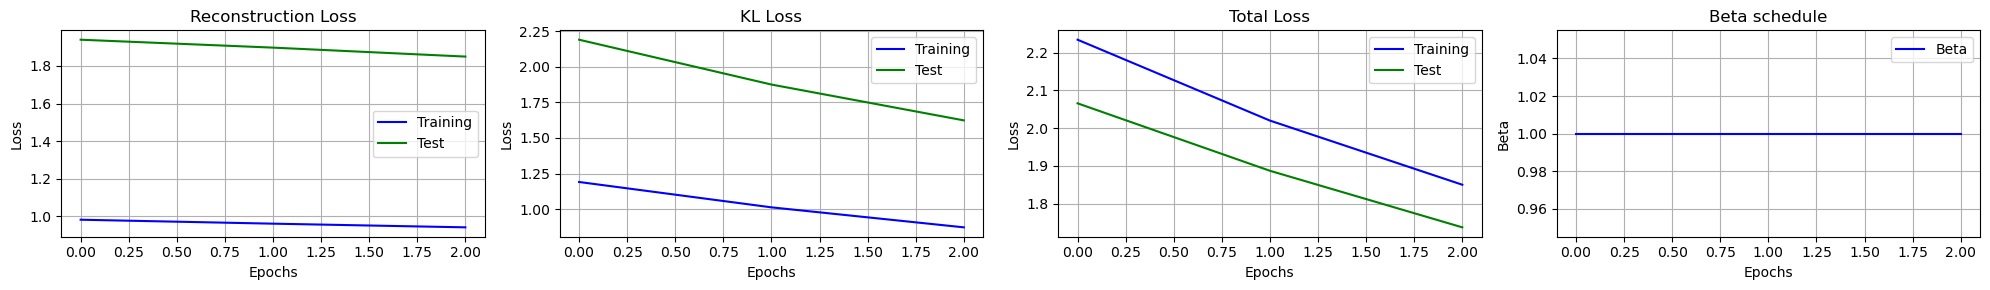

In [21]:
plot_losses(rec_losses, kl_losses, epoch_losses, val_rec_losses, val_kl_losses, val_epoch_losses, betas)

# Reconstruction and Generation

In [22]:
print(f"Number of steps to predict ahead: {n_ahead}")

Number of steps to predict ahead: 20


In [23]:
#----------------------------------------------------------------------
#
#  Sampling predictions
#
#----------------------------------------------------------------------


def sample_predictions(N_SAMPLES=3, model=None, X_valid=None, y_valid=None, n_steps=None, n_ahead=None, device=None):
    
    idx = np.random.randint(0, len(X_valid), N_SAMPLES)
    X_valid_subset = X_valid[idx]
    y_valid_subset = y_valid[idx]
    
    fig, axs = plt.subplots(N_SAMPLES, 1, figsize=(16, 3 * N_SAMPLES))
    for i in range(N_SAMPLES):
        input = torch.tensor(X_valid_subset[i], device=device).unsqueeze(1).unsqueeze(2)
        # print(f"input shape : {input.shape}")
        target = torch.tensor(y_valid_subset[i], device=device)
        target = target.cpu().detach().numpy()
        mu_predictions, logvar_predictions, mu_full_x, logvar_full_x = model.predict(input, n_ahead)
              
        # display data
        axs[i].plot(input.squeeze().cpu().detach().numpy(), color='blue', marker=".", linewidth=1, label="input")
        axs[i].plot(np.arange(len(target))+n_steps, target, color='red', marker="o", linewidth=1, label="ground truth")
        
        # display predictions and credible intervals
        all_times = np.arange(n_steps+n_ahead)
        mu_full_x = mu_full_x.squeeze().cpu().detach().numpy()
        logvar_full_x = logvar_full_x.squeeze().cpu().detach().numpy()
        std_full_x = np.exp(logvar_full_x / 2)
        
        axs[i].scatter(all_times, mu_full_x, color='green', marker="x", linewidth=1, label="reconstructed and predicted")
        axs[i].fill_between(all_times, mu_full_x-2*std_full_x, mu_full_x+2*std_full_x, color='orange', label='+/- 2 std', alpha=0.2)
        
        axs[i].set_title(f"Time series {idx[i]}")
        axs[i].set_xlabel("Time")
        axs[i].set_ylabel("Value")
        axs[i].legend()
        axs[i].grid(True)
        
    plt.tight_layout()
    plt.show()

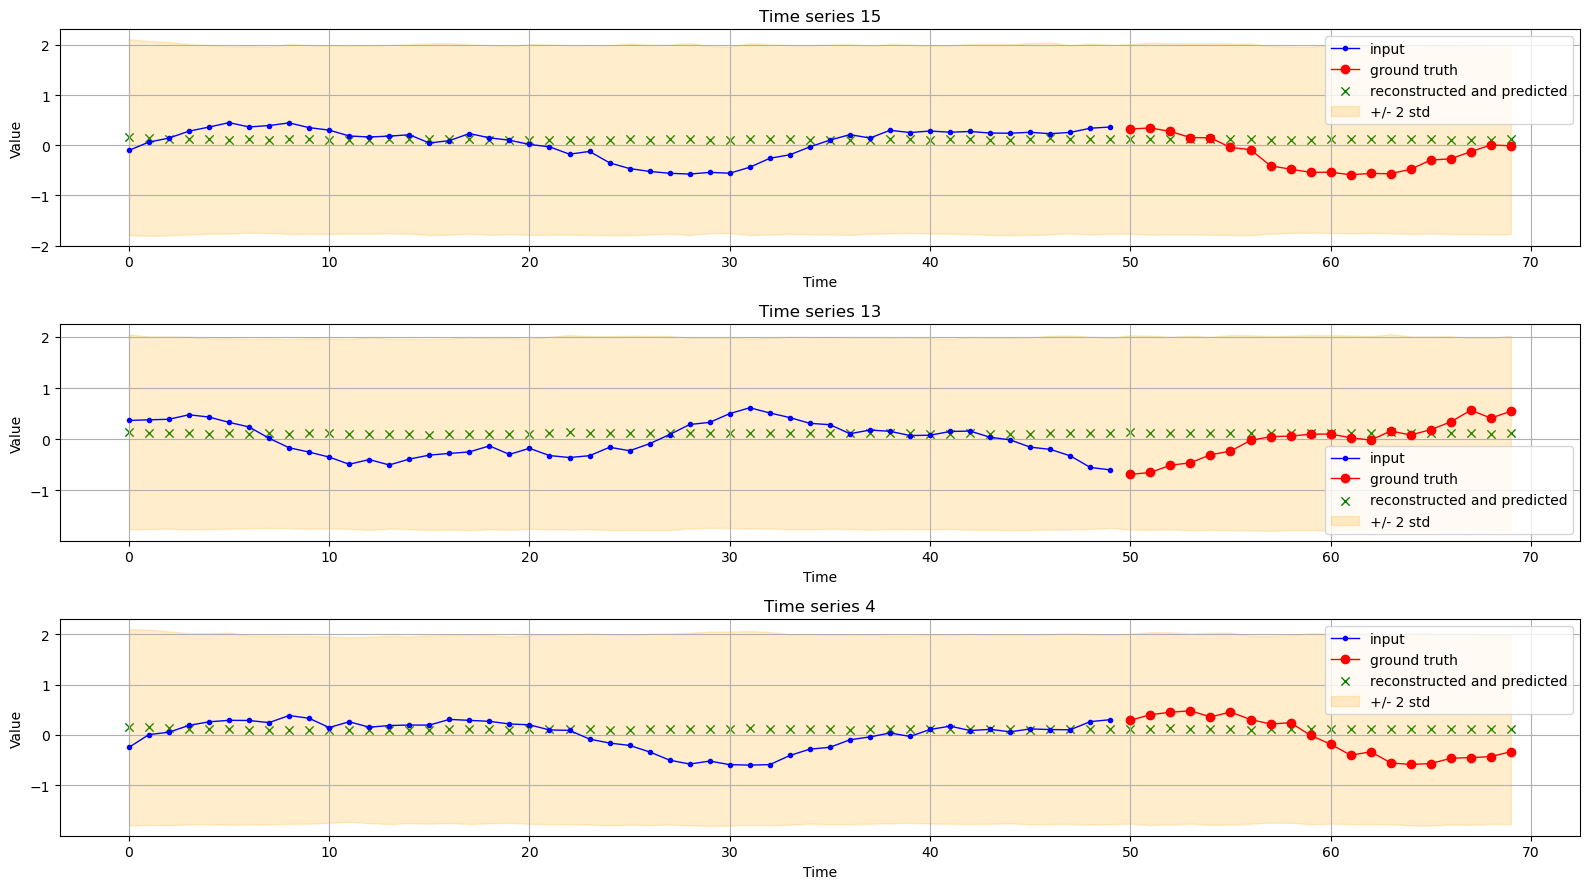

In [24]:
sample_predictions(N_SAMPLES=3, model=vrnn, X_valid=X_valid, y_valid=y_valid, n_steps=n_steps, n_ahead=n_ahead, device=device)

In [25]:
# computing the L2 loss on the test set
vrnn_past_mses = []
vrnn_predictions_mses = []
vrnn_reconstructions_mean = np.zeros((len(X_valid), n_steps))
vrnn_reconstructions_cov = np.zeros((len(X_valid), n_steps))
vrnn_predictions_mean = np.zeros((len(X_valid), n_ahead))
vrnn_predictions_cov = np.zeros((len(X_valid), n_ahead))

for i in range(len(X_valid)):
        input = torch.tensor(X_valid[i], device=device).unsqueeze(1).unsqueeze(2)
        mu_predictions, logvar_predictions, mu_full_x, logvar_full_x = vrnn.predict(input, n_ahead)
                     
        # compute predictions and credible intervals
        all_times = np.arange(n_steps+n_ahead)
        mu_full_x = mu_full_x.squeeze().cpu().detach().numpy()
        logvar_full_x = logvar_full_x.squeeze().cpu().detach().numpy()
        std_full_x = np.exp(logvar_full_x / 2)
        
        # log predictions
        vrnn_predictions_mean[i] = mu_full_x[n_steps:]
        vrnn_predictions_cov[i] = std_full_x[n_steps:]**2
        vrnn_reconstructions_mean[i] = mu_full_x[:n_steps]
        vrnn_reconstructions_cov[i] = std_full_x[:n_steps]**2
        
        # compute MSE for the past
        mse = (mu_full_x[:n_steps] - X_valid[i])**2
        # print(f"Time series {i+1} - MSE over past: {mse.mean():.6f}")
        vrnn_past_mses.append(mse.mean())
        # compute MSE for the future
        mse = (mu_full_x[n_steps:] - y_valid[i])**2
        # print(f"Time series {i+1} - MSE over prediction horizon: {mse.mean():.6f}")
        vrnn_predictions_mses.append(mse.mean())
        
print(f"VRNN : Average MSE over past: {np.mean(vrnn_past_mses):.3f} ± {np.std(vrnn_past_mses):.3f}")
print(f"VRNN : Average MSE over prediction horizon: {np.mean(vrnn_predictions_mses):.3f} ± {np.std(vrnn_predictions_mses):.3f}")

VRNN : Average MSE over past: 0.119 ± 0.021
VRNN : Average MSE over prediction horizon: 0.120 ± 0.054


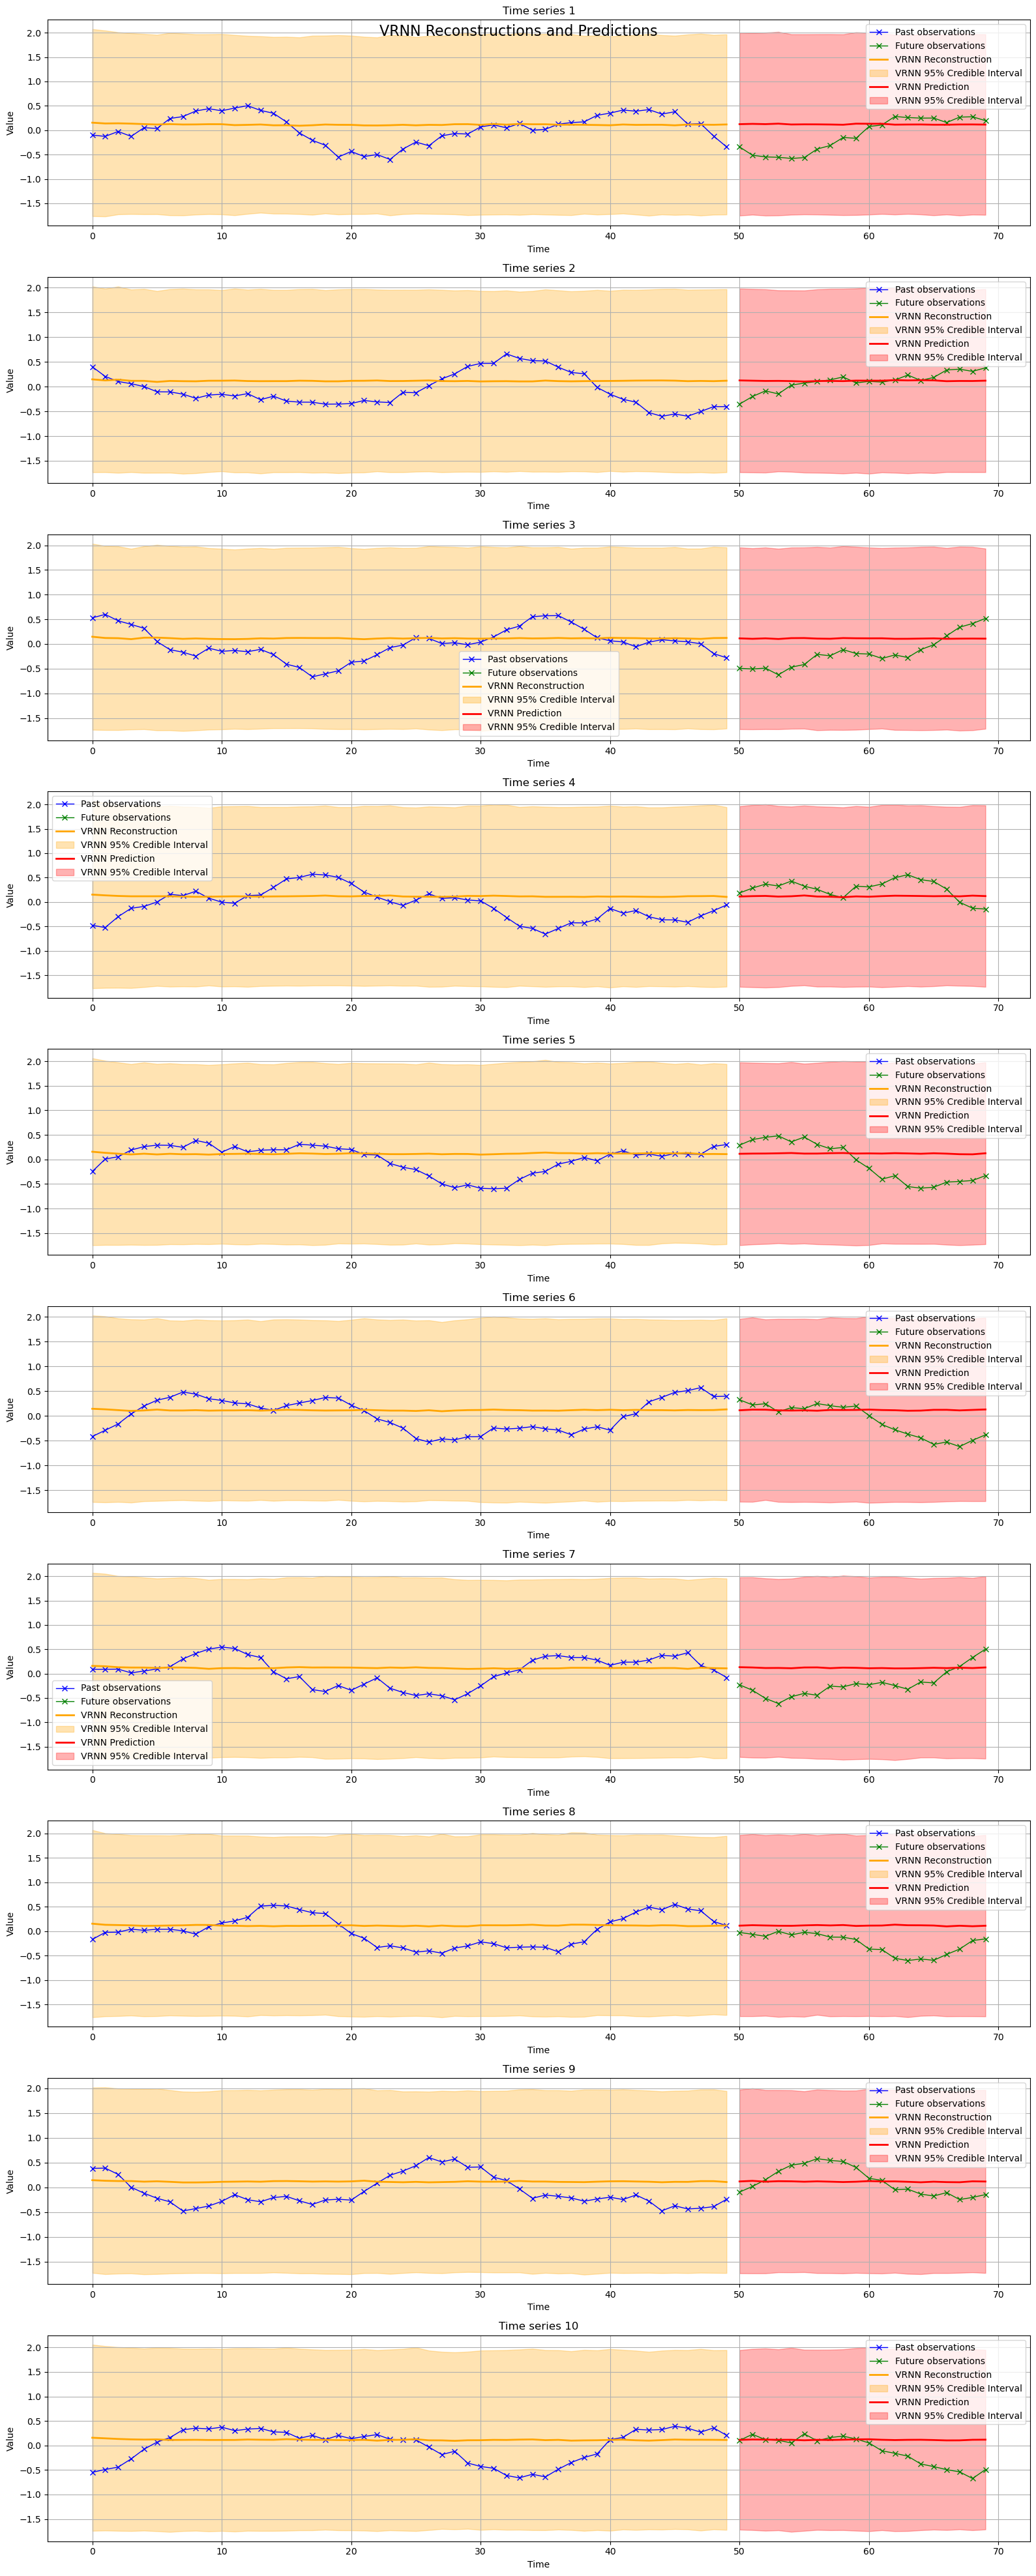

In [26]:
# plots
N_SAMPLES = 10

fig, axs = plt.subplots(N_SAMPLES, 1, figsize=(16, 4 * N_SAMPLES))
for i in range(N_SAMPLES):
    axs[i].plot(np.arange(n_steps), X_valid[i], color='blue', marker="x", linewidth=1, label="Past observations")
    axs[i].plot(np.arange(n_steps, n_steps+n_ahead), y_valid[i], color='green', marker="x", linewidth=1, label="Future observations")
    axs[i].plot(np.arange(n_steps), vrnn_reconstructions_mean[i], color='orange', linewidth=2, label="VRNN Reconstruction")
    axs[i].fill_between(np.arange(n_steps), 
                        vrnn_reconstructions_mean[i] - 1.96 * np.sqrt(vrnn_reconstructions_cov[i]),
                        vrnn_reconstructions_mean[i] + 1.96 * np.sqrt(vrnn_reconstructions_cov[i]),
                        color='orange', alpha=0.3, label="VRNN 95% Credible Interval")
    axs[i].plot(np.arange(n_steps, n_steps+n_ahead), vrnn_predictions_mean[i], color='red', linewidth=2, label="VRNN Prediction")
    axs[i].fill_between(np.arange(n_steps, n_steps+n_ahead), 
                        vrnn_predictions_mean[i] - 1.96 * np.sqrt(vrnn_predictions_cov[i]),
                        vrnn_predictions_mean[i] + 1.96 * np.sqrt(vrnn_predictions_cov[i]),
                        color='red', alpha=0.3, label="VRNN 95% Credible Interval")
    axs[i].set_title(f"Time series {i+1}")
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Value")
    axs[i].legend()
    axs[i].grid(True)
    
fig.suptitle("VRNN Reconstructions and Predictions", fontsize=16)
plt.tight_layout()
plt.show()

# Plotting Reconstruction Losses

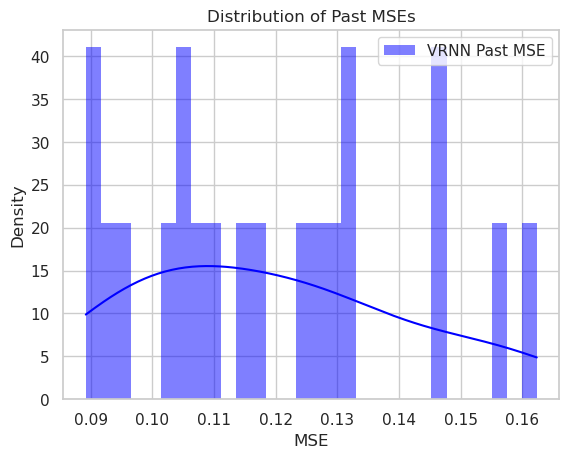

In [27]:
sns.set(style="whitegrid")

sns.histplot(vrnn_past_mses, color='blue', bins=30, label='VRNN Past MSE', kde=True, stat="density", linewidth=0)
plt.title("Distribution of Past MSEs")
plt.xlabel("MSE")
plt.ylabel("Density")
plt.legend()
plt.show()

# Summary